In [67]:
#import code from previous parts
from pathlib import Path
from warnings import simplefilter
import requests as r
import json
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from pytrends.request import TrendReq
pytrend = TrendReq(hl='en-US', tz=360)


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [68]:
# Get a list of all the card information. I chose card name, card ID, and the set:
CardList = [['Giratina VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',478100,'Crown Zenith'],
            ['Arceus VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',478101,'Crown Zenith'],
            ['Mewtwo VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',477057,'Crown Zenith'],
            ['Origin Forme Dialga VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',478099,'Crown Zenith'],
            ['Origin Forme Palkia VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',478097,'Crown Zenith'],
            ['Leafeon VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',477060,'Crown Zenith'],
            ['Glaceon VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',477061,'Crown Zenith'],
            ['Suicune V - Crown Zenith: Galarian Gallery (CRZ:GG)',478067,'Crown Zenith'],
            ['Elesas Sparkle (Full Art) - Crown Zenith (CRZ)',477241,'Crown Zenith'],
            ['Pikachu (Secret) - Crown Zenith (CRZ)',478103,'Crown Zenith'],
            ['Lugia V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)',451834,'Silver Tempest'],
            ['Rayquaza VMAX - SWSH12: Silver Tempest Trainer Gallery (SWSH12: TG)',452034,'Silver Tempest'],
            ['Unown V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)',451825,'Silver Tempest'],
            ['Serena (Full Art) - SWSH12: Silver Tempest (SWSH12)',451841,'Silver Tempest'],
            ['Lugia VSTAR (Secret) (202) - SWSH12: Silver Tempest (SWSH12)',451995,'Silver Tempest'],
            ['Regidrago V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)',451832,'Silver Tempest'],
            ['Lugia VSTAR (Secret) (211) - SWSH12: Silver Tempest (SWSH12)',452009,'Silver Tempest'],
            ['Alolan Vulpix VSTAR (Secret) - SWSH12: Silver Tempest (SWSH12)',451987,'Silver Tempest'],
            ['Skuntank V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)',451829,'Silver Tempest'],
            ['Friends in Galar - SWSH12: Silver Tempest Trainer Gallery (SWSH12: TG)',452039,'Silver Tempest'],
            ['Giratina V (Alternate Full Art) - SWSH11: Lost Origin (SWSH11)',284137,'Lost Origin'],
            ['Aerodactyl V (Alternate Full Art) - SWSH11: Lost Origin (SWSH11)',284122,'Lost Origin'],
            ['Pikachu VMAX - SWSH11: Lost Origin Trainer Gallery (SWSH11: TG)',284283,'Lost Origin'],
            ['Rotom V (Alternate Full Art) - SWSH11: Lost Origin (SWSH11)',284119,'Lost Origin'],
            ['Galarian Perrserker V (Alternate Full Art) - SWSH11: Lost Origin (SWSH11)',284135,'Lost Origin'],
            ['Pikachu V - SWSH11: Lost Origin Trainer Gallery (SWSH11: TG)',284278,'Lost Origin'],
            ['Giratina VSTAR (201) (Secret) - SWSH11: Lost Origin (SWSH11)',284156,'Lost Origin'],
            ['Giratina VSTAR (212) (Secret) - SWSH11: Lost Origin (SWSH11)',284167,'Lost Origin'],
            ['Eternatus VMAX - SWSH11: Lost Origin Trainer Gallery (SWSH11: TG)',284295,'Lost Origin'],
            ['Aerodactyl VSTAR (Secret) - SWSH11: Lost Origin (SWSH11)',284154,'Lost Origin']]

In [69]:
CRZ_startdate = '01/20/2023'  #Crown Zenith
SIT_startdate = '11/11/2022'  #Silver Tempest
LOR_startdate = '09/09/2022'  #Lost Origin

CRZ_enddate = ''
SIT_enddate = ''
LOR_enddate = ''

#CRZ was released less than 90 days than when this was written
#Added this in so I wouldnt have to rewrite it on a later date
#Get current date and compare to Crown Zenith release date; Grab up to 90 days if available

date_1 = datetime.datetime.strptime(CRZ_startdate, "%m/%d/%Y")
end_date = date_1 + datetime.timedelta(days=90)

current_date = datetime.datetime.today()

if end_date >= current_date:
    CRZ_enddate = str(current_date.date())
else:
    CRZ_enddate = str(end_date.date())
    
#Reformat dates to find 90 days after sets released
    
CRZ_startdate = datetime.datetime.strptime(CRZ_startdate, "%m/%d/%Y").date()
SIT_startdate = datetime.datetime.strptime(SIT_startdate, "%m/%d/%Y").date()
LOR_startdate = datetime.datetime.strptime(LOR_startdate, "%m/%d/%Y").date()

SIT_enddate = SIT_startdate + datetime.timedelta(days=90)
LOR_enddate = LOR_startdate + datetime.timedelta(days=90)

#Reformat dates to strings. Used later when requesting data from Google Trends

CRZ_startdate = str(CRZ_startdate)
SIT_startdate = str(SIT_startdate)
LOR_startdate = str(LOR_startdate)

SIT_enddate = str(SIT_enddate)
LOR_enddate = str(LOR_enddate)

In [70]:
#Check to see everything was formatted correctly and is working
print('Crown Zenith is from '+ CRZ_startdate + ' to ' + CRZ_enddate + '.')
print('Silver Tempest is from '+ SIT_startdate + ' to ' + SIT_enddate + '.')
print('Lost Origin is from '+ LOR_startdate + ' to ' + LOR_enddate + '.')

Crown Zenith is from 2023-01-20 to 2023-03-21.
Silver Tempest is from 2022-11-11 to 2023-02-09.
Lost Origin is from 2022-09-09 to 2022-12-08.


In [71]:
CrownZenithCards = [['Date']]
SilverTempestCards = [['Date']]
LostOriginCards = [['Date']]

i = 0
for i in range(0, len(CardList)):
    if CardList[i][2] == 'Crown Zenith':
        CrownZenithCards[0].append(CardList[i][0])
    elif CardList[i][2] == 'Silver Tempest':
        SilverTempestCards[0].append(CardList[i][0])
    elif CardList[i][2] == 'Lost Origin':
        LostOriginCards[0].append(CardList[i][0])
    i = i + 1

#Example of what is currently in the set data. The first will be used as headers/indexes
CrownZenithCards[0]

['Date',
 'Giratina VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',
 'Arceus VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',
 'Mewtwo VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',
 'Origin Forme Dialga VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',
 'Origin Forme Palkia VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',
 'Leafeon VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',
 'Glaceon VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',
 'Suicune V - Crown Zenith: Galarian Gallery (CRZ:GG)',
 'Elesas Sparkle (Full Art) - Crown Zenith (CRZ)',
 'Pikachu (Secret) - Crown Zenith (CRZ)']

In [72]:
#the first cards for each set are going to be used to also grab dates
firstCardCRZ = 0
firstCardSIL = 0
firstCardLOR = 0

for i in range(0, len(CardList)):
    
    #url to post
    #changed to get the cardID by the list. will be used in loop later
    action_postURL = 'https://infinite-api.tcgplayer.com/price/history/'+ str(CardList[i][1]) + '?range=annual'
    
    #get data from that URL
    res = r.get(action_postURL)
    
    #put the data coming in from res into values as json
    values = res.json()
    
    #check how many dates are in each pull
    NumberOfDays= values['count']
    
    #look in each pull for what set the card is in
    if CardList[i][2] == 'Crown Zenith':
        j = 0
        while j < NumberOfDays:
            #check to see if card is first of set and within date range we chose earlier
            if firstCardCRZ == 0 and values['result'][j]['date'] >= CRZ_startdate and values['result'][j]['date'] <= CRZ_enddate:
                #check how many of each card was on the market. this removes the '0' market value if the quantity is 0.
                if int(values['result'][j]['variants'][0]['quantity']) > 0:
                    quantCheckPrice = float(values['result'][j]['variants'][0]['marketPrice'])
                else: quantCheckPrice = None
                #put the card in the set data
                CrownZenithCards.append([values['result'][j]['date'], quantCheckPrice])
            #if not the first card, just check the date is within range
            elif firstCardCRZ > 0 and values['result'][j]['date'] >= CRZ_startdate and values['result'][j]['date'] <= CRZ_enddate:
                #check how many of each card was on the market. this removes the '0' market value if the quantity is 0.
                if int(values['result'][j]['variants'][0]['quantity']) > 0:
                    quantCheckPrice = float(values['result'][j]['variants'][0]['marketPrice'])
                else: quantCheckPrice = None
                #find the date in the set data and append to the correct list
                for k in range(1, len(CrownZenithCards)):
                    if values['result'][j]['date'] == CrownZenithCards[k][0]:
                        CrownZenithCards[k].append(quantCheckPrice)
            j = j + 1
        firstCardCRZ = 1
    #rinse and repeat the same thing we did in CrownZenithCards for SilverTempest
    elif CardList[i][2] == 'Silver Tempest':
        j = 0
        while j < NumberOfDays:
            if firstCardSIL == 0 and values['result'][j]['date'] >= SIT_startdate and values['result'][j]['date'] <= SIT_enddate:
                if int(values['result'][j]['variants'][0]['quantity']) > 0:
                    quantCheckPrice = float(values['result'][j]['variants'][0]['marketPrice'])
                else: quantCheckPrice = None
                SilverTempestCards.append([values['result'][j]['date'], quantCheckPrice])
            elif firstCardSIL > 0 and values['result'][j]['date'] >= SIT_startdate and values['result'][j]['date'] <= SIT_enddate:
                if int(values['result'][j]['variants'][0]['quantity']) > 0:
                    quantCheckPrice = float(values['result'][j]['variants'][0]['marketPrice'])
                else: quantCheckPrice = None
                for k in range(1, len(SilverTempestCards)):
                    if values['result'][j]['date'] == SilverTempestCards[k][0]:
                        SilverTempestCards[k].append(quantCheckPrice)
            j = j + 1
        firstCardSIL = 1
    #rinse and repeat the same thing we did in CrownZenithCards/SilverTempest for LostOrigin
    elif CardList[i][2] == 'Lost Origin':
        j = 0
        while j < NumberOfDays:
            if firstCardLOR == 0 and values['result'][j]['date'] >= LOR_startdate and values['result'][j]['date'] <= LOR_enddate:
                if int(values['result'][j]['variants'][0]['quantity']) > 0:
                    quantCheckPrice = float(values['result'][j]['variants'][0]['marketPrice'])
                else: quantCheckPrice = None
                LostOriginCards.append([values['result'][j]['date'], quantCheckPrice])
            elif firstCardLOR > 0 and values['result'][j]['date'] >= LOR_startdate and values['result'][j]['date'] <= LOR_enddate:
                if int(values['result'][j]['variants'][0]['quantity']) > 0:
                    quantCheckPrice = float(values['result'][j]['variants'][0]['marketPrice'])
                else: quantCheckPrice = None
                for k in range(1, len(LostOriginCards)):
                    if values['result'][j]['date'] == LostOriginCards[k][0]:
                        LostOriginCards[k].append(quantCheckPrice)
            j = j + 1
        firstCardLOR = 1
    i = i + 1

In [73]:
#example of what is currently in each set data:
for i in range(0, len(SilverTempestCards)):
    print(SilverTempestCards[i][0] + ' || MarketPrice: ' + str(SilverTempestCards[i][1]))
    i = i + 1

Date || MarketPrice: Lugia V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)
2023-02-06 || MarketPrice: 188.96
2023-01-30 || MarketPrice: 200.08
2023-01-23 || MarketPrice: 186.58
2023-01-16 || MarketPrice: 200.36
2023-01-09 || MarketPrice: 204.49
2023-01-02 || MarketPrice: 199.64
2022-12-26 || MarketPrice: 213.39
2022-12-19 || MarketPrice: 212.08
2022-12-12 || MarketPrice: 207.76
2022-12-05 || MarketPrice: 216.83
2022-11-28 || MarketPrice: 227.51
2022-11-21 || MarketPrice: 222.56
2022-11-14 || MarketPrice: 233.85


In [74]:
#reversing order of the dates and prices
CrownZenithCards_asc = []
SilverTempestCards_asc = []
LostOriginCards_asc = []

CrownZenithCards_asc.append(CrownZenithCards[0])
SilverTempestCards_asc.append(SilverTempestCards[0])
LostOriginCards_asc.append(LostOriginCards[0])

for i in range(1, len(CrownZenithCards)):
    CrownZenithCards_asc.append(CrownZenithCards[-i])

for i in range(1, len(SilverTempestCards)):
    SilverTempestCards_asc.append(SilverTempestCards[-i])

for i in range(1, len(LostOriginCards)):
    LostOriginCards_asc.append(LostOriginCards[-i])

In [75]:
# Set up indexes to work with deterministic process

CRZ_Cards = CrownZenithCards_asc[0][1:]
CRZ_df = pd.DataFrame(data=CrownZenithCards_asc)
CRZ_df.columns = CRZ_df.iloc[0]
CRZ_df = CRZ_df[1:]
CRZ_df.index = pd.to_datetime(CRZ_df['Date'])
date_index = CRZ_df.index.to_period('D')
CRZ_df.set_index(date_index)
y = CRZ_df.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=3,        # 2 = quadratic trend,3 = cubic trend ; tried both
    drop=True,      # drop terms to avoid collinearity
)

X = dp.in_sample()  # features for the training data

# split the data for train/test set

idx_train, idx_test = train_test_split(
    y.index, test_size=3, shuffle=False,
)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]

y_train, y_test = y.loc[idx_train], y.loc[idx_test]

model = LinearRegression(fit_intercept=False)

# Dataset added date back in. Remove it or model won't work

y_train = y_train.drop("Date", axis=1)
y_test = y_test.drop("Date", axis=1)

# Correct the index

y_train.index = y_train.index.to_period('D')

y_test.index = y_test.index.to_period('D')

# Fit the model

model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

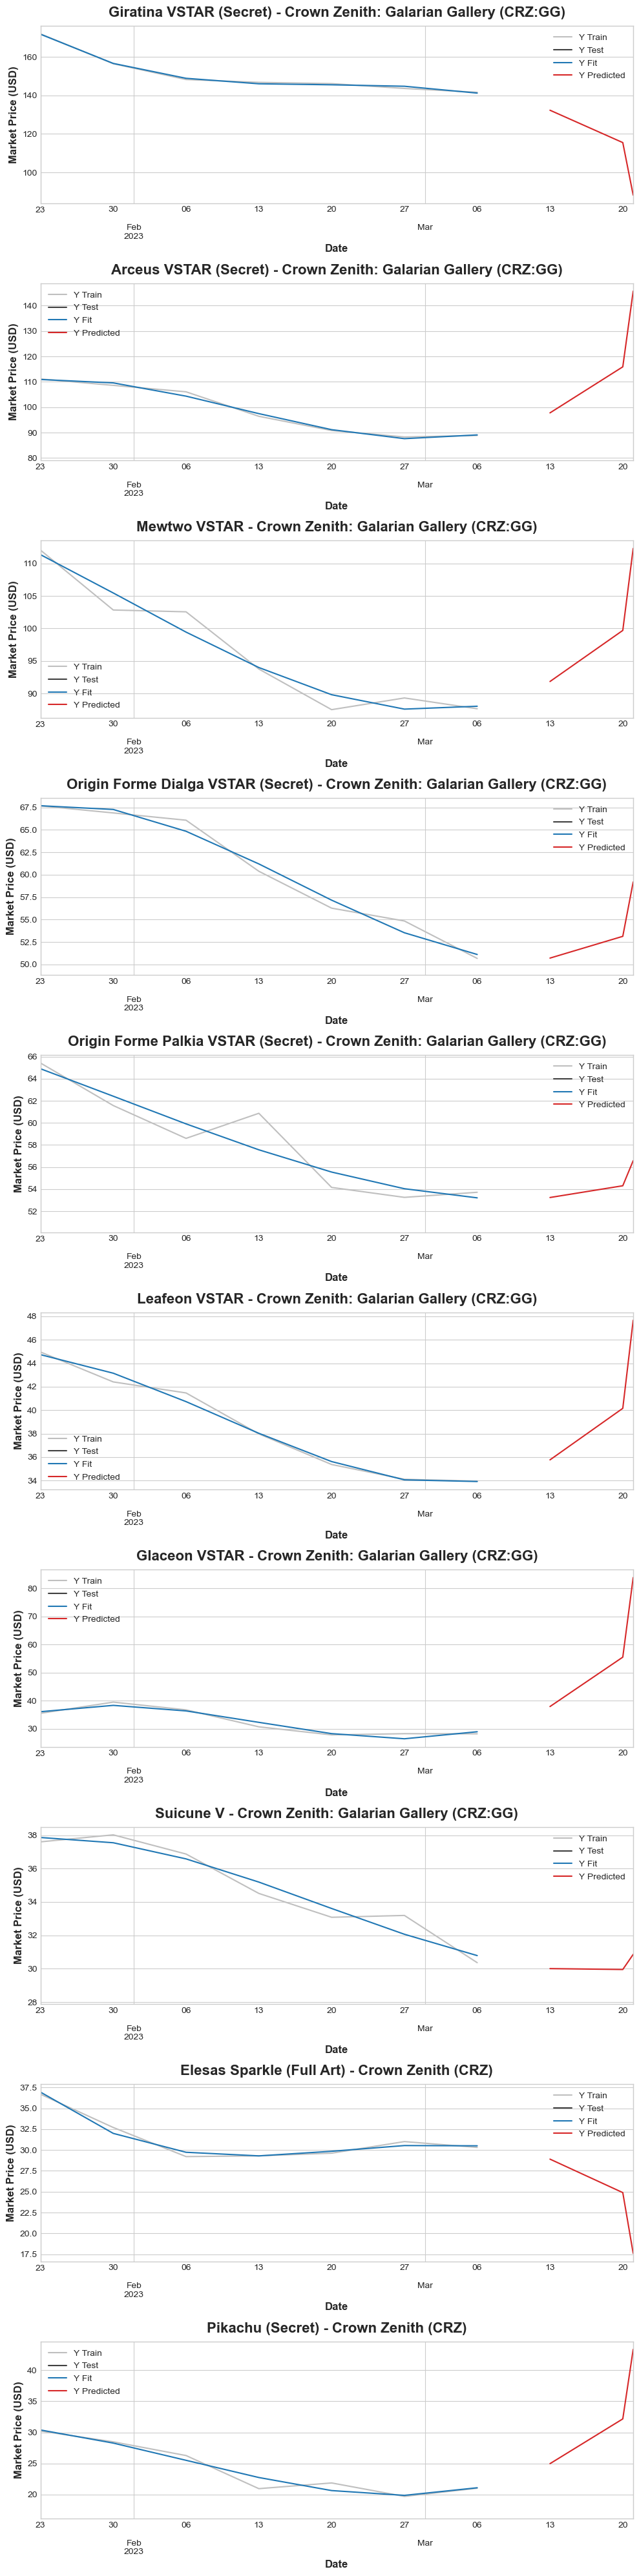

In [76]:
# Plot
axs = y_train.plot(color='0.75', subplots=True, sharex=False,figsize=(10,40),title=CRZ_Cards, ylabel='Market Price (USD)', label = 'Y Train')
axs = y_test.plot(color='0.25', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Test')
axs = y_fit.plot(color='C0', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Fit')
axs = y_pred.plot(color='C3', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Predicted')
##axs = plt.subplots(figsize=(10,7))
#plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Market Price (USD)')
for ax in axs: ax.legend(('Y Train', 'Y Test', 'Y Fit', 'Y Predicted'))

In [77]:
# Set up indexes to work with deterministic process

SIL_Cards = SilverTempestCards_asc[0][1:]
SIL_df = pd.DataFrame(data=SilverTempestCards_asc)
SIL_df.columns = SIL_df.iloc[0]
SIL_df = SIL_df[1:]
SIL_df.index = pd.to_datetime(SIL_df['Date'])
date_index = SIL_df.index.to_period('D')
SIL_df.set_index(date_index)
y = SIL_df.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=3,        # 2 = quadratic ,3 = cubic trend ; tried both
    drop=True,      # drop terms to avoid collinearity
)

X = dp.in_sample()  # features for the training data

# split the data for train/test set

idx_train, idx_test = train_test_split(
    y.index, test_size=3, shuffle=False,
)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]

y_train, y_test = y.loc[idx_train], y.loc[idx_test]

model = LinearRegression(fit_intercept=False)

# Dataset added date back in. Remove it or model won't work

y_train = y_train.drop("Date", axis=1)
y_test = y_test.drop("Date", axis=1)

# Correct the index

y_train.index = y_train.index.to_period('D')

y_test.index = y_test.index.to_period('D')

# Fit the model

model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

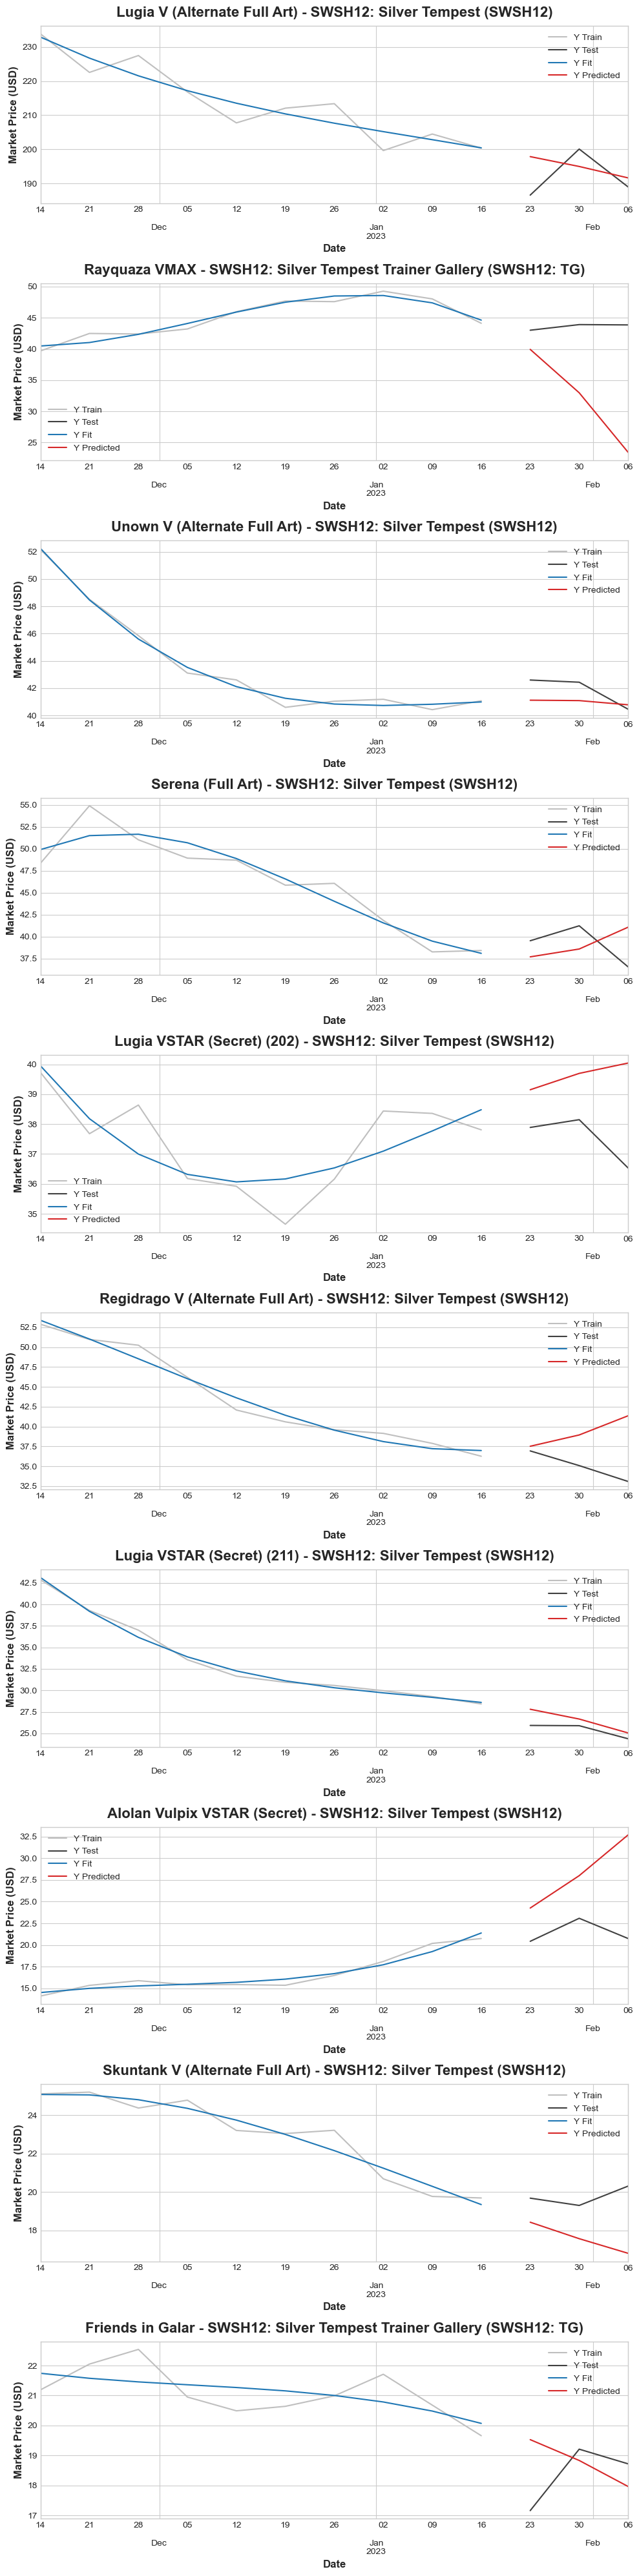

In [78]:
# Plot
axs = y_train.plot(color='0.75', subplots=True, sharex=False,figsize=(10,40),title=SIL_Cards, ylabel='Market Price (USD)', label = 'Y Train')
axs = y_test.plot(color='0.25', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Test')
axs = y_fit.plot(color='C0', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Fit')
axs = y_pred.plot(color='C3', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Predicted')
##axs = plt.subplots(figsize=(10,7))
#plt.legend()
for ax in axs: ax.legend(('Y Train', 'Y Test', 'Y Fit', 'Y Predicted'))

In [79]:
# Set up indexes to work with deterministic process

LOR_Cards = LostOriginCards_asc[0][1:]
LOR_df = pd.DataFrame(data=LostOriginCards_asc)
LOR_df.columns = LOR_df.iloc[0]
LOR_df = LOR_df[1:]
LOR_df.index = pd.to_datetime(LOR_df['Date'])
date_index = LOR_df.index.to_period('D')
LOR_df.set_index(date_index)
y = LOR_df.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=3,        # 2 = quadratic ,3 = cubic trend ; tried both
    drop=True,      # drop terms to avoid collinearity
)

X = dp.in_sample()  # features for the training data

# split the data for train/test set

idx_train, idx_test = train_test_split(
    y.index, test_size=3, shuffle=False,
)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]

y_train, y_test = y.loc[idx_train], y.loc[idx_test]

model = LinearRegression(fit_intercept=False)

# Dataset added date back in. Remove it or model won't work

y_train = y_train.drop("Date", axis=1)
y_test = y_test.drop("Date", axis=1)

# Correct the index

y_train.index = y_train.index.to_period('D')

y_test.index = y_test.index.to_period('D')

# Fit the model

model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

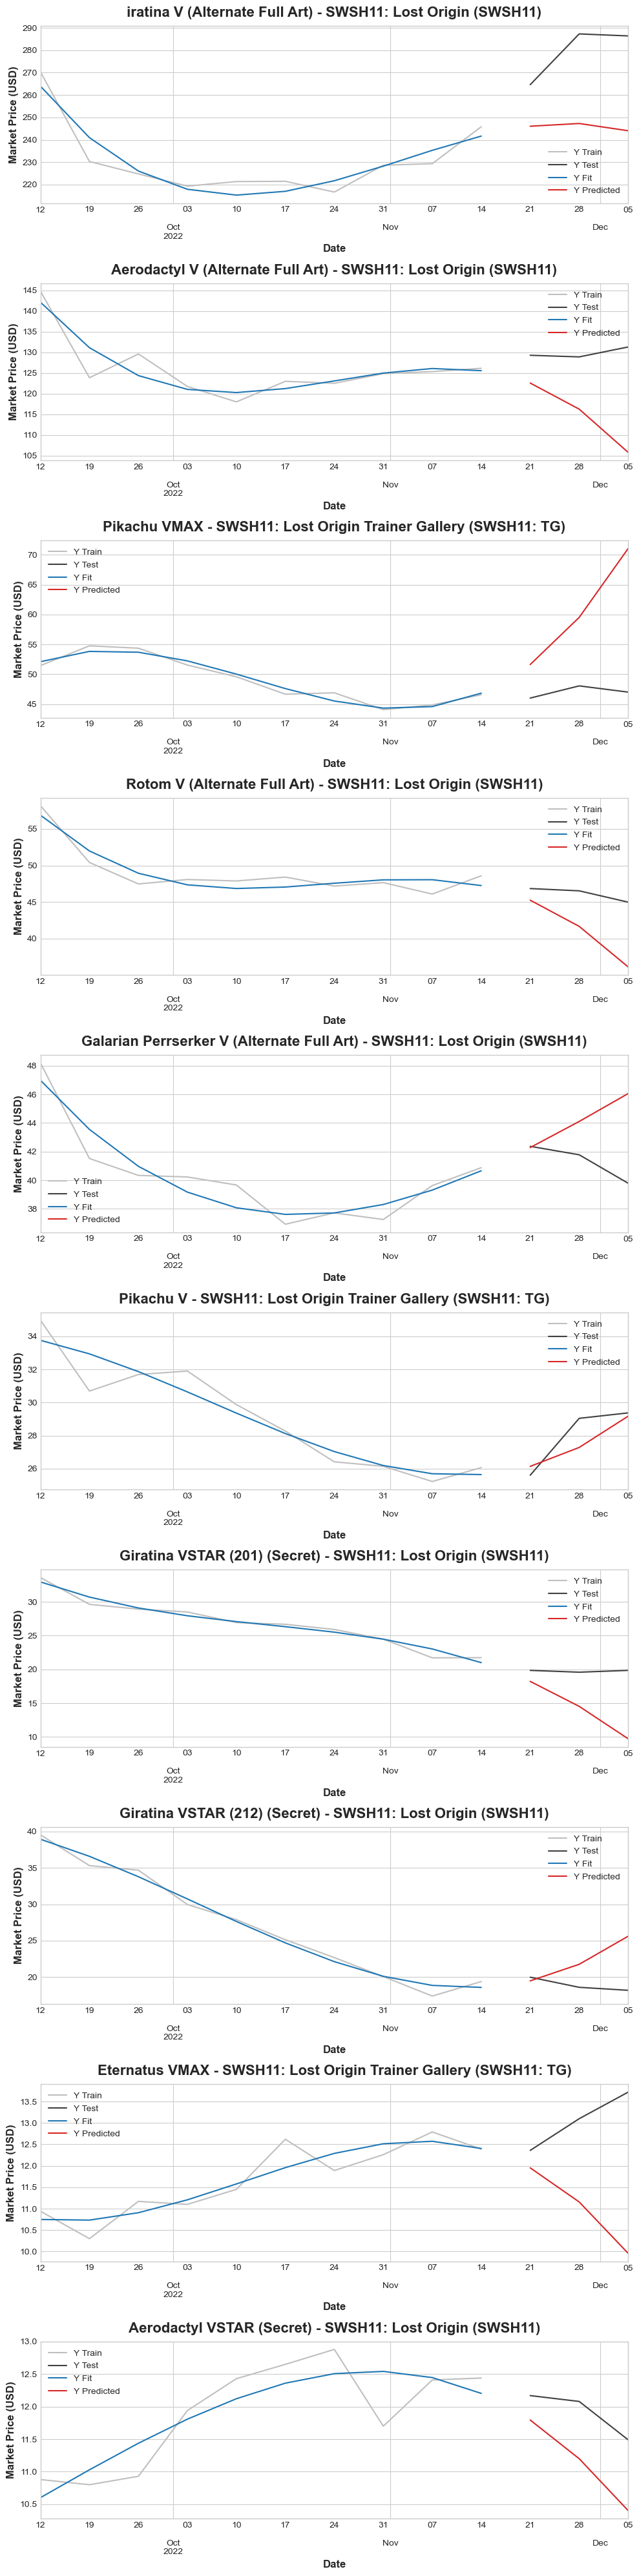

In [80]:
# Plot
axs = y_train.plot(color='0.75', subplots=True, sharex=False,figsize=(10,40),title=LOR_Cards, ylabel='Market Price (USD)', label = 'Y Train')
axs = y_test.plot(color='0.25', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Test')
axs = y_fit.plot(color='C0', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Fit')
axs = y_pred.plot(color='C3', subplots=True, sharex=False, ax=axs,figsize=(10,40), ylabel='Market Price (USD)', label = 'Y Predicted')
##axs = plt.subplots(figsize=(10,7))
#plt.legend()
for ax in axs: ax.legend(('Y Train', 'Y Test', 'Y Fit', 'Y Predicted'))